# Projet STA211 — Modélisation supervisée : Classification de publicités

Ce notebook fait suite à l’analyse exploratoire des données (01_EDA_Preprocessing), et se concentre sur la **modélisation supervisée** dans le cadre du projet STA211.

**Objectif** : prédire si une observation correspond à une publicité (`ad.`) ou non (`noad.`) à partir des données du jeu Internet Advertisements.

**Fichiers utilisés** :
- `data_train.csv` : données d’entraînement préalablement nettoyées et explorées
- `data_test.csv` : données de test à prédire

**Étapes couvertes ici** :
1. Préparation des données pour la modélisation (équilibration des données, standardisation…)
2. Implémentation de plusieurs modèles supervisés (logistique, arbres, forêts, etc.)
3. Évaluation comparative des performances (F1-score, AUC, matrice de confusion)
4. Gestion du déséquilibre des classes si nécessaire (SMOTE, pondération)
5. Génération d’un fichier `my_pred.csv` pour soumission

> Ce notebook suppose que le prétraitement initial (gestion des NA, exploration univariée et bivariée, transformations) a été réalisé dans le notebook EDA (`01_EDA_Preprocessing`).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [2]:
import sys
import os

def is_colab():
    """Détecte si le code s'exécute dans Google Colab."""
    try:
        import google.colab  # noqa
        return True
    except ImportError:
        return False

# === 1. Définir le chemin racine en fonction de l'environnement ===
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    ROOT_DIR = "/content/drive/Othercomputers/Mon_pc_hp/Documents/Projects/STA211_Challenge_2025"
else:
    ROOT_DIR = r"C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025"

# === 2. Définir les dossiers du projet ===
MODULE_DIR      = os.path.join(ROOT_DIR, "modules")
RAW_DATA_DIR    = os.path.join(ROOT_DIR, "data", "raw")
DATA_PROCESSED  = os.path.join(ROOT_DIR, "data", "processed")
MODELS_DIR      = os.path.join(ROOT_DIR, "models")
FIGURES_DIR     = os.path.join(ROOT_DIR, "outputs", "figures")

# Créer les dossiers s’ils n’existent pas
for folder in [MODULE_DIR, RAW_DATA_DIR, DATA_PROCESSED, MODELS_DIR, FIGURES_DIR]:
    os.makedirs(folder, exist_ok=True)

# === 3. Ajouter MODULE_DIR au path pour l'import de modules maison ===
if MODULE_DIR not in sys.path:
    sys.path.insert(0, MODULE_DIR)

# === 4. Afficher les chemins pour vérification ===
print("Environnement : Colab" if is_colab() else "Environnement : local")
print("ROOT_DIR       =", ROOT_DIR)
print("MODULE_DIR     =", MODULE_DIR)
print("RAW_DATA_DIR   =", RAW_DATA_DIR)
print("DATA_PROCESSED =", DATA_PROCESSED)
print("FIGURES_DIR    =", FIGURES_DIR)
print("MODELS_DIR     =", MODELS_DIR)


Environnement : local
ROOT_DIR       = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025
MODULE_DIR     = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\modules
RAW_DATA_DIR   = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\data\raw
DATA_PROCESSED = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\data\processed
FIGURES_DIR    = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\outputs\figures
MODELS_DIR     = C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\models


In [3]:
# === Importation des bibliothèques principales ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Affichage plus lisible
sns.set(style="whitegrid")
plt.style.use('seaborn-v0_8')

# === Scikit-learn : preprocessing, modèles, évaluation ===
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    make_scorer
)

# === Modèles classiques ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# === Gestion du déséquilibre ===
from imblearn.over_sampling import SMOTE

# Supprimer les warnings inutiles
import warnings
warnings.filterwarnings('ignore')


# Chargement des données

In [4]:
from data_preprocessing import load_data

# Chemin complet vers le fichier CSV final
final_csv_path = os.path.join(DATA_PROCESSED, "df_final_knn.csv")

# Chargement des données
data = load_data(final_csv_path)


Dimensions du dataset: (2459, 180)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2459 entries, 0 to 2458
Columns: 180 entries, X4 to X3_boxcox
dtypes: float64(3), int64(176), object(1)
memory usage: 3.4+ MB

Aperçu des données :


,X4,outcome,X1244,X352,X1400,X969,X1345,X1436,X1230,X1119,...,X265,X963,X1133,X555,X1432,X1495,X870,X1_log,X2_boxcox,X3_boxcox
0,1,ad.,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,4.836282,9.870992,0.000000
1,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,3.526361,12.284012,2.056352
2,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
3,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.110874,15.640028,2.182903
4,1,ad.,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,4.094345,15.550788,2.182411


# Préparation des données

In [13]:
pip install joblib

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import joblib
import os

# === Séparation features / target ===
X = data.drop(columns=["outcome"])
y = (data["outcome"] == "ad.").astype(int)  # 1 si pub, 0 sinon

# === Split en train / test (80/20), avec stratification ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# === Sauvegarde des colonnes utilisées ===
columns_used = X_train.columns.tolist()
joblib.dump(columns_used, os.path.join(DATA_PROCESSED, "columns_used.pkl"))

# === Standardisation des données ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Rééquilibrage par SMOTE ===
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Vérification
print(f"Taille du train initial : {X_train.shape}")
print(f"Taille après SMOTE :     {X_train_res.shape}")
print("Distribution y (après SMOTE) :")
print(pd.Series(y_train_res).value_counts(normalize=True).round(3))


Taille du train initial : (1967, 179)
Taille après SMOTE :     (3384, 179)
Distribution y (après SMOTE) :
outcome
0    0.5
1    0.5
Name: proportion, dtype: float64


In [6]:
# Sauvegarde du scaler pour réutilisation sur d'autres jeux (ex: data_test.csv)
scaler_path = os.path.join(DATA_PROCESSED, "scaler_knn.pkl")
joblib.dump(scaler, scaler_path)
print(f"Scaler sauvegardé à : {scaler_path}")

Scaler sauvegardé à : C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\data\processed\scaler_knn.pkl


# Définition des modèles

In [ ]:
models = {
    "Logistic Regression": (
        LogisticRegression(max_iter=1000),
        {"C": [0.1, 1, 10]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(random_state=42),
        {"max_depth": [5, 10, 20]}
    ),
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [50, 100]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"n_neighbors": [3, 5, 7]}
    ),
    "SVM": (
        SVC(probability=True),
        {"C": [0.1, 1], "kernel": ["linear", "rbf"]}
    ),
    "Neural Net": (
        MLPClassifier(max_iter=500, random_state=42),
        {"hidden_layer_sizes": [(100,), (50, 50)], "alpha": [0.0001, 0.001]}
    )
}


# Entraînement avec optimisation F1

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import joblib

results = {}
best_overall_model = None
best_score = 0
best_model_name = ""

print("=== Entraînement et optimisation par validation croisée ===")

for name, (model, params) in models.items():
    print(f"\n🔍 Optimisation {name}")

    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        scoring=make_scorer(f1_score),
        cv=5,
        n_jobs=-1
    )

    grid.fit(X_train_res, y_train_res)
    best_model = grid.best_estimator_

    # Prédiction sur le test set d'origine (non resamplé)
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model, "predict_proba") else None

    # Affichage
    print("Confusion Matrix :")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report :")
    print(classification_report(y_test, y_pred, digits=3))

    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None
    print(f"✅ F1-score : {f1:.4f}" + (f" | AUC : {auc:.4f}" if auc else ""))

    results[name] = (f1, auc)

    # Mise à jour si meilleur modèle
    if f1 > best_score:
        best_score = f1
        best_overall_model = best_model
        best_model_name = name

# Résumé final
print(f"\n🏆 Meilleur modèle : {best_model_name} (F1 = {best_score:.4f})")

# Sauvegarde du meilleur modèle sous un nom standard
best_model_path = os.path.join(MODELS_DIR, "best_model.joblib")
joblib.dump(best_overall_model, best_model_path)
print(f"📦 Meilleur modèle sauvegardé à : {best_model_path}")



=== Entraînement et optimisation par validation croisée ===

🔍 Optimisation Logistic Regression
Confusion Matrix :
[[404  19]
 [ 12  57]]
Classification Report :
              precision    recall  f1-score   support

           0      0.971     0.955     0.963       423
           1      0.750     0.826     0.786        69

    accuracy                          0.937       492
   macro avg      0.861     0.891     0.875       492
weighted avg      0.940     0.937     0.938       492

✅ F1-score : 0.7862 | AUC : 0.9018

🔍 Optimisation Decision Tree
Confusion Matrix :
[[419   4]
 [ 13  56]]
Classification Report :
              precision    recall  f1-score   support

           0      0.970     0.991     0.980       423
           1      0.933     0.812     0.868        69

    accuracy                          0.965       492
   macro avg      0.952     0.901     0.924       492
weighted avg      0.965     0.965     0.964       492

✅ F1-score : 0.8682 | AUC : 0.8437

🔍 Optimisation Ra

# Comparaison des scores

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Transformation des résultats en DataFrame
results_df = pd.DataFrame(results, index=["F1-score", "AUC"]).T.sort_values("F1-score", ascending=False)

# Tracé
fig, ax1 = plt.subplots(figsize=(10, 5))
results_df[["F1-score", "AUC"]].plot(kind="bar", ax=ax1, colormap="viridis", edgecolor="black")
plt.title("Comparaison des modèles - F1-score et AUC")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



NameError: name 'results' is not defined

# Importance des variables (Random Forest)

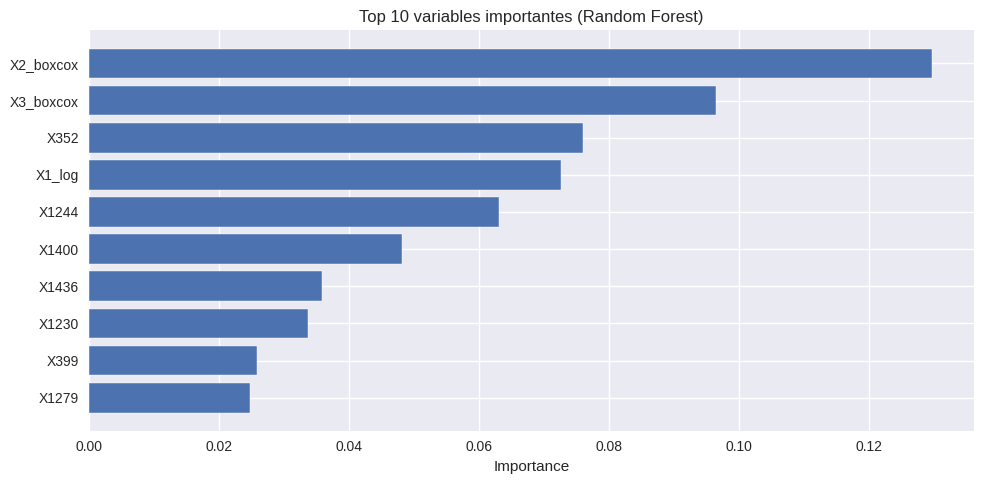

In [ ]:
best_rf = models["Random Forest"][0].fit(X_train_res, y_train_res)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importance")
plt.title("Top 10 variables importantes (Random Forest)")
plt.tight_layout()
plt.show()

# Prédictions finales sur `data_test.csv`

In [6]:
import joblib
best_model = joblib.load(os.path.join(MODELS_DIR, "best_model.joblib"))

In [7]:
from predict_preprocessing import generate_submission

generate_submission(
    test_file="data_test.csv",
    imputer_file="imputer_knn_k20.pkl",
    scaler_file="scaler_knn.pkl",
    model_file="best_model.joblib"
)


Dimensions du dataset: (820, 1558)

Infos colonnes :
<class 'pandas.core.frame.DataFrame'>
Index: 820 entries, 2460 to 3279
Columns: 1558 entries, X1 to X1558
dtypes: float64(4), int64(1554)
memory usage: 9.8 MB

Aperçu des données :


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X1549,X1550,X1551,X1552,X1553,X1554,X1555,X1556,X1557,X1558
2460,57.0,468.0,8.2105,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2461,60.0,468.0,7.8000,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2462,90.0,52.0,0.5777,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2463,60.0,468.0,7.8000,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
2464,90.0,60.0,0.6666,1.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


✅ Fichier de prédiction généré : C:\Users\aella\OneDrive\Documents\Projects\STA211_Challenge_2025\my_pred.csv


In [8]:
def read_pred(file, n=820):
    """Vérifie la conformité du fichier de prédiction au format attendu."""
    y_pred = pd.read_csv(file, header=None).squeeze()

    if len(y_pred) != n:
        raise ValueError(f"❌ Le fichier contient {len(y_pred)} lignes, attendu : {n}.")

    if y_pred.isnull().any():
        raise ValueError("❌ Le fichier contient des valeurs manquantes (NA).")

    unique_vals = set(y_pred.unique())
    if not unique_vals.issubset({"ad.", "noad."}):
        raise ValueError(f"❌ Valeurs invalides détectées : {unique_vals}")

    if len(unique_vals) == 1:
        print("⚠️ Avertissement : une seule classe prédite. Risque de sur-apprentissage.")

    print("✅ Fichier conforme. Prêt pour soumission.")
    return y_pred


# Validation locale du fichier

In [9]:
read_pred("C:/Users/aella/OneDrive/Documents/Projects/STA211_Challenge_2025/my_pred.csv")

✅ Fichier conforme. Prêt pour soumission.


0        ad.
1        ad.
2        ad.
3        ad.
4        ad.
       ...  
815    noad.
816    noad.
817    noad.
818    noad.
819    noad.
Name: 0, Length: 820, dtype: object